# Summary

Motivation: Create a little *n*-layer Neural Network (fully connected multilayer perceptron), by following the class lecture [CS231n](https://cs231n.github.io/neural-networks-case-study/)


Table of Content:
- 1) Generate some Data
- Train Softmax Non-Linear Classifier
-- 2) Initialize the Parameters
-- 3) Compute the Class Scores
-- 4) Compute the Loss
-- 5) Computing the Analytic Gradient with Backpropagation
-- 6) Perform Parameter Updates


1) Data

$X_{300x2} \rightarrow$ Data Matrix 

$y_{300x1} \rightarrow$ Classes (3x)

$W_{2x3} \rightarrow$ Weights

$b_{1x3} \rightarrow$ bias


2) Score Function

>$ s = f(x_i,W,b) = W_{x_i}+b$


3) Cross-entropy Loss

>$L_i = - log(\frac{e^{f_{y_i}}}{\displaystyle\sum_j e^{f_j}})$

>$DL = \frac{1}{N}\displaystyle\sum_j L_i$

>$RL = \frac{1}{2}\lambda\displaystyle\sum_K\displaystyle\sum_L W^2_{k,l}$

>$L = \frac{1}{N}\displaystyle\sum_{\substack{i}}L_i + \frac{1}{2} \lambda\sum_{K}\sum_{L}W^2_{k,l}$ 

>$L = \frac{1}{N}\displaystyle\sum_{\substack{i}} - log(\frac{e^{f_{y_i}}}{\displaystyle\sum_j e^{f_j}}) + \frac{1}{2} \lambda\sum_{K}\sum_{L}W^2_{k,l}$ 

> $L = DL + RL$


4) Backprob and Parameter Updates

Loss for one example

>$p_k = \frac{e^{f_k}}{\displaystyle\sum_{\substack{j}}e^{f_j}}$

>$L_i = -log(p_{y_i})$

Derive Gradient $\partial L_i / \partial f_k$

>$\frac{\partial L_i}{\partial f_k} = p_k -1 (y_i = k)$

>$\frac{d}{dw}(\frac{1}{2}\lambda w^2) = \lambda w$ 

> Regularization gradient (reg*W)


```
  dW += reg*W

```

> Parameter Update



```
  W += -step_size * dW
  b += -step_size * db
```





In [ ]:
# https://playground.tensorflow.org/
# http://vision.stanford.edu/teaching/cs231n-demos/linear-classify/

# Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# DATA

In [18]:
N = 200       # Number of Datapoints
D = 2         # Number of Dimensions (Feature Space)
K = 9        # Number of Classes

## Helper Functions

In [16]:
def generateData(noise, rad, blackhole, spin):
  X = np.zeros((N*K,D))
  y = np.zeros(N*K, dtype='uint8')
  for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(blackhole,rad,N) #radius
    t = np.linspace(j*4,(j+spin)*4,N) + np.random.randn(N) * noise
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
  return X,y

def plotScatter(X,y):
  plt.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=plt.cm.Spectral)
  plt.show()

# Generate Data

Training Data: # (1800, 2) (1800,)


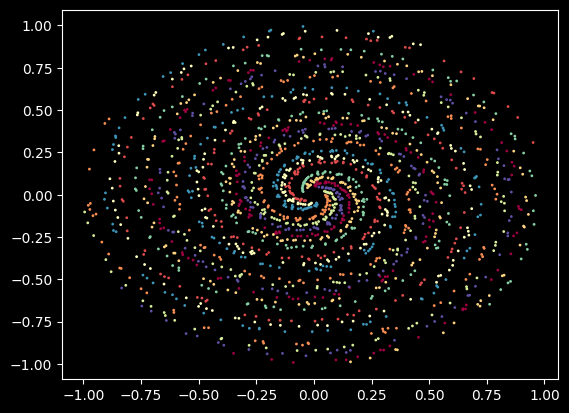

Test Data: # (1800, 2) (1800,)


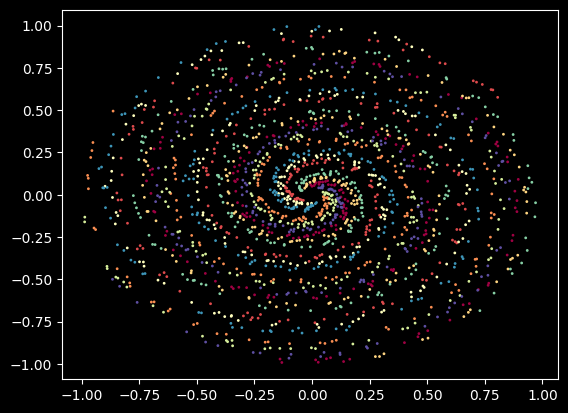

In [19]:
X_train, y_train = generateData(noise=0.1, rad=1, blackhole=0.05, spin=4)
X_test, y_test = generateData(noise=0.15, rad=1, blackhole=0.05, spin=4)

print("Training Data: #", X_train.shape, y_train.shape)
plotScatter(X_train, y_train)
print("Test Data: #", X_test.shape, y_test.shape)
plotScatter(X_test, y_test)

# Class-Model

In [43]:
class Model():
  def __init__(self, network: list, regulizer: float) -> None:
    '''
    Initialize and build the Network
    '''
    super().__init__()
    self.reg = regulizer
    self.layers = network
    self.n_layers = len(network) - 1
    self.hidden_layers = []
    self.weights = []
    self.bias = []
    self.history = []
    self.build()


  def build(self) -> None:
    '''
    Setup Network Weights and Bias
    '''
    for l in range(self.n_layers):
      W = 0.01 * np.random.randn(self.layers[l], self.layers[l + 1]) 
      b = np.zeros((1,self.layers[l + 1]))
      self.weights.append(W)
      self.bias.append(b)


  def summary(self) -> str:
    '''
    Plot a small Summary of the models total parameters
    '''
    total = 0
    output = 'Network Summary:\n'
    output += '---------------------\n'
    for i in range(self.n_layers):
      output += 'Weights: ' + str(NN.weights[i].shape) + ' - Bias: ' + str(NN.bias[i].shape) + '\n'
      total += NN.weights[i].shape[0] * NN.weights[i].shape[1] + 1 * NN.weights[i].shape[0]
    output += '---------------------\n'
    output += 'Total Params: ' + str(total)
    return output


  def train(self, X: np.array, y: np.array, learning_rate: list, gd_loop: int, output: int) -> list:
    '''
    Train the Neural Network by computing the Analytical Gradient with Backpropagation
    '''
    num_examples = X.shape[0]
    # gradient descent loop
    for i in range(gd_loop):
      # 2) Forward Pass: Score Function
      self.hidden_layers = []
      hidden_layer = np.maximum(0, np.dot(X, self.weights[0]) + self.bias[0])     # into first layer
      self.hidden_layers.append(hidden_layer)
      for w in range(len(self.weights) - 2):
        hidden_layer = np.maximum(0, np.dot(hidden_layer, self.weights[w + 1]) + self.bias[w + 1])  # n - layers
        self.hidden_layers.append(hidden_layer) 
      scores = np.dot(hidden_layer, self.weights[len(self.weights) - 1]) + self.bias[len(self.bias) - 1]    # into last layer

      # 3) compute the class probs
      exp_scores = np.exp(scores)
      probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

      # 4) compute the loss: avg cross-entropy loss and reg loss
      correct_logprobs = -np.log(probs[range(num_examples), y])
      data_loss = np.sum(correct_logprobs)/num_examples
      reg_loss = 0
      for w in range(len(self.weights)):
        reg_loss += 0.5 * self.reg * np.sum(self.weights[w] * self.weights[w])
      loss = data_loss + reg_loss

      # Decrease learning rate by threshold conditions
      for condition in learning_rate:
        if len(condition)==1:
          self.step_size = condition[0]  
        elif condition[0] >= loss:
          self.step_size = condition[1]  

      # Output the current Loss and store it in history
      if i % output == 0:      
        self.history.append(loss)
        print('Step:', i, '\tloss: ', loss, '\tlr: ', self.step_size)

      # 5) compute the gradients on scores
      dscores = probs
      dscores[range(num_examples), y] -= 1
      dscores /= num_examples

      # Backprop into hidden layers and store gradients
      dW, db = [], []
      dhidden = dscores
      for x in reversed(range(len(self.weights))):
        if x == 0: break
        dW.append(np.dot(self.hidden_layers[x - 1].T, dhidden))
        db.append(np.sum(dhidden, axis=0, keepdims=True))
        dhidden = np.dot(dhidden, self.weights[x].T)
        dhidden[self.hidden_layers[x - 1] <= 0] = 0
      dW.append(np.dot(X.T, dhidden))
      db.append(np.sum(dhidden, axis=0, keepdims=True))

      # add regularization gradient contribution
      dW.reverse()
      db.reverse()
      for x in reversed(range(len(dW))):
        dW[x] += self.reg * self.weights[x]

      # 6) perform parameter updates
      for x in range(len(self.weights)):
        self.weights[x] += -self.step_size * dW[x]
        self.bias[x] += -self.step_size * db[x]

    return [loss]


  def predict(self, x) -> np.array:
    '''
    Predict function
    '''
    # forward Pass through all layers
    for w in range(len(self.weights)):
      x = np.maximum(0, np.dot(x, self.weights[w]) + self.bias[w])
    predicted_class = np.argmax(x, axis=1)
    return predicted_class


  def evaluate(self, X, y) -> np.array:
    '''
    Evaluate
    '''
    predicted_class = self.predict(X)
    return np.mean(predicted_class == y)  


# Training

## Build Model

In [44]:
input_dim = D     # number of input features
output_dim = K    # number of class labels
NN = Model(network=[input_dim, 200, 200, output_dim], regulizer=1e-6)
print(NN.summary())

Network Summary:
---------------------
Weights: (2, 200) - Bias: (1, 200)
Weights: (200, 200) - Bias: (1, 200)
Weights: (200, 9) - Bias: (1, 9)
---------------------
Total Params: 42602


## Train (GD Loop)

In [45]:
%%time
#lr = [[1.0]]                           # no decrease, default lr [[learning_rate]]
lr = [[1.0], [1.0, 0.1], [0.1, 0.01]]   # decrease learning rate by loss threshold [[at_threshold, new_learning_rate]]
NN.train(X_train,
         y_train,
         learning_rate=lr,
         gd_loop=40_000,
         output=1_000)


Step: 0 	loss:  2.1972281479325884 	lr:  1.0
Step: 1000 	loss:  2.1851942002547835 	lr:  1.0
Step: 2000 	loss:  2.1828685534392784 	lr:  1.0
Step: 3000 	loss:  2.1747908797453666 	lr:  1.0
Step: 4000 	loss:  2.14336059234802 	lr:  1.0
Step: 5000 	loss:  1.9940771810044364 	lr:  1.0
Step: 6000 	loss:  1.7210170741602058 	lr:  1.0
Step: 7000 	loss:  1.2451672020426303 	lr:  1.0
Step: 8000 	loss:  0.5704666768463494 	lr:  0.1
Step: 9000 	loss:  0.4688816186302166 	lr:  0.1
Step: 10000 	loss:  0.3930927940918965 	lr:  0.1
Step: 11000 	loss:  0.3327306949544164 	lr:  0.1
Step: 12000 	loss:  0.2836922513986208 	lr:  0.1
Step: 13000 	loss:  0.24402838986312833 	lr:  0.1
Step: 14000 	loss:  0.2119246947241768 	lr:  0.1
Step: 15000 	loss:  0.1855939914529976 	lr:  0.1
Step: 16000 	loss:  0.1640199893002134 	lr:  0.1
Step: 17000 	loss:  0.14603805564766517 	lr:  0.1
Step: 18000 	loss:  0.13096162009495838 	lr:  0.1
Step: 19000 	loss:  0.11820411397241123 	lr:  0.1
Step: 20000 	loss:  0.107325042

[0.08495090748917422]

## Evaluate & Loss History

Train Acc: 0.9972222222222222
Test Acc: 0.9305555555555556


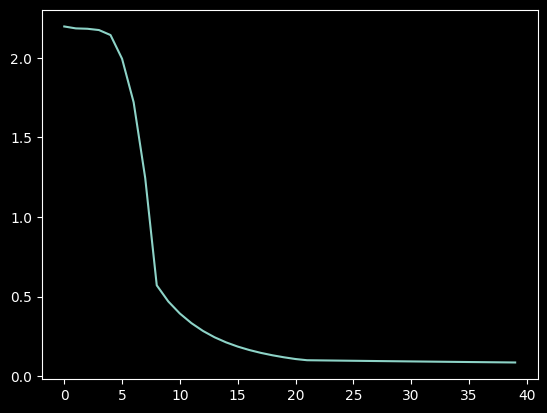

In [46]:
print('Train Acc:', NN.evaluate(X_train, y_train))
print('Test Acc:', NN.evaluate(X_test, y_test))
plt.plot(NN.history)
plt.show()

## Prediction Heatmap (boundaries)

Class Predition Heatmap (Structure)


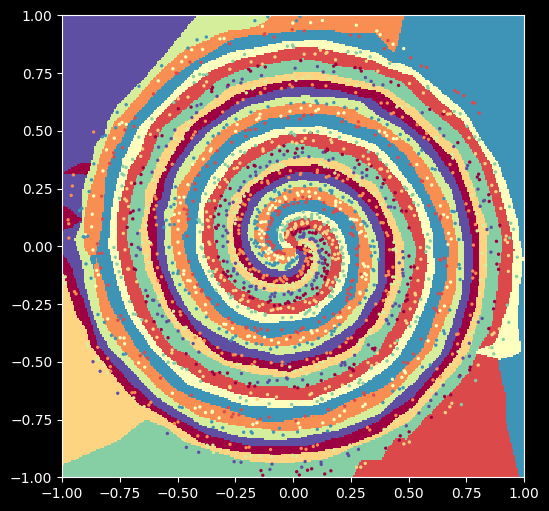

In [47]:
dim = 300  #dim x dim
nx, ny = (dim,dim)
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
buff = []
for i in range(x.shape[0]):
  for j in range(y.shape[0]):
    buff.append([x[i],y[j]])

p_map = NN.predict(np.array(buff))
p_map = np.array(p_map, dtype=np.float64).reshape(dim,dim)

print("Class Predition Heatmap (Structure)")
fig = plt.figure(figsize=(6,6))
extent = -1, 1, -1, 1
# Info: Heatmap Spectral Colors are not precisely matching train/test class colors
im1 = plt.imshow(p_map, cmap=plt.cm.Spectral, interpolation='nearest', extent=extent)
im2 = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=2, cmap=plt.cm.Spectral)
plt.show()